In [1]:
%%capture
!pip install pennylane --upgrade
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [4]:
!git clone https://github.com//tungnguyen2313/QCNN_classification
%cd QCNN_classification/QCNN

Cloning into 'QCNN_classification'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 122.33 KiB | 3.14 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/QCNN/QCNN/QCNN_classification/QCNN


# Dataset

In [7]:
import tensorflow as tf
import numpy as np

classes = [0, 1]
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Data Pre-processing
x_train_filter_01 = np.where((y_train == classes[0]) | (y_train == classes[1]))
x_test_filter_01 = np.where((y_test == classes[0]) | (y_test == classes[1]))

X_train, X_test = x_train[x_train_filter_01], x_test[x_test_filter_01]
Y_train, Y_test = y_train[x_train_filter_01], y_test[x_test_filter_01]

print(f'The number of data in the training set: {x_train.shape[0]}')
print(f'The number of data in the testing set: {x_test.shape[0]}')

print(f'The number of data in the training set: {X_train.shape[0]}')
print(f'The number of data in the testing set: {X_test.shape[0]}')

The number of data in the training set: 60000
The number of data in the testing set: 10000
The number of data in the training set: 12665
The number of data in the testing set: 2115


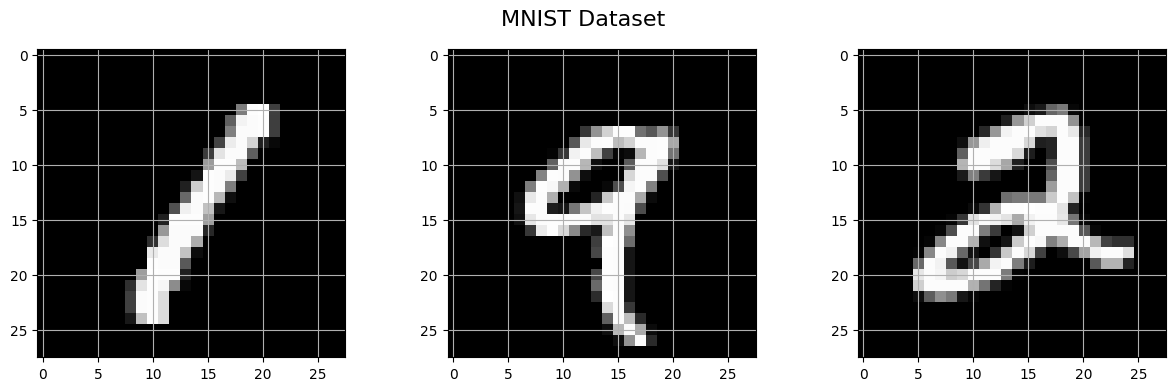

In [11]:
import matplotlib.pyplot as plt
# Plot the images after each step
def plot_images(images, titles, commontitle):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 4))
    plt.suptitle(commontitle, fontsize=16)
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap='gray')
        # axes[i].set_title(title)
        axes[i].axis('on')
        axes[i].grid('on')
    plt.show()

# Create a list of images and corresponding titles for plotting
images = [x_train[3], x_train[4], x_train[5] ]
titles = ['Original Image', 'Resized Train Image', 'Resized Test Image']

# Plot the images
plot_images(images, titles, "MNIST Dataset")

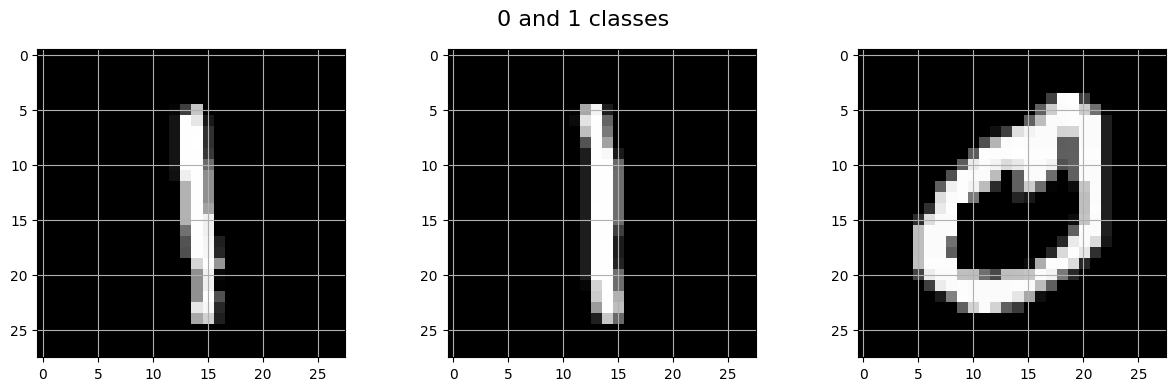

In [13]:
# Create a list of images and corresponding titles for plotting
images = [X_train[3], X_train[4], X_train[5] ]
titles = ['Original Image', 'Resized Train Image', 'Resized Test Image']

# Plot the images
plot_images(images, titles, "0 and 1 classes")

In [14]:
X_train, X_test = X_train[..., np.newaxis] / 255.0, X_test[..., np.newaxis] / 255.0  # normalize the data


Y_train = [1 if y == classes[0] else 0 for y in Y_train]
Y_test = [1 if y == classes[0] else 0 for y in Y_test]

X_train = tf.image.resize(X_train[:], (256, 1)).numpy()
X_test = tf.image.resize(X_test[:], (256, 1)).numpy()
X_train, X_test = tf.squeeze(X_train).numpy(), tf.squeeze(X_test).numpy()

# Training

In [15]:
# Cross entropy loss function
def cross_entropy(labels, preds):
    loss = 0
    for l, p in zip(labels, preds):
        c_entropy = l * (anp.log(p[l])) + (1 - l) * anp.log(1 - p[1 - l])
        loss = loss + c_entropy
    return -1 * loss


def cost(parameters, X, Y, U, U_parameters, num_qubits=8):
    preds = [quantum_circuit.QCNN(x, parameters, U, U_parameters, num_qubits) for x in X]
    loss = cross_entropy(Y, preds)
    return loss


def accuracy_test(preds, labels):
    acc = 0
    for l,p in zip(labels, preds):
        if p[0] > p[1]:
            P = 0
        else:
            P = 1
        if P == l:
            acc = acc + 1
    return acc / len(labels)

In [16]:
import pennylane as qml
import autograd.numpy as anp
from pennylane import numpy as np
import quantum_circuit

import time


# Training
steps = 300
learning_rate = 0.01
batch_size = 25
num_qubits = 8


## Understand this part please
Unitaries = ['U_SU4',  'U_SU4_no_pooling', 'U_9_1D']
U_num_params = [15, 15, 2]

result_all = []
test_all = []

for i in range(len(Unitaries)):
    U = Unitaries[i]
    U_params = U_num_params[i]

    if U == 'U_SU4_no_pooling' or U == 'U_SU4_1D' or U == 'U_9_1D':
        total_params = U_params * 3
    else:
        total_params = U_params * 3 + 2 * 3


    params = np.random.randn(total_params, requires_grad=True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    start_time = time.time()
    for it in range(steps):

        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        params, cost_new = opt.step_and_cost(
            lambda v: cost(v, X_batch, Y_batch, U, U_params, num_qubits),
            params)
        loss_history.append(cost_new)

        if it % 10 == 0:
            end_time = time.time()
            print("iteration: ", it, " cost: ", cost_new, " duration: ", end_time - start_time)
            start_time = time.time()

    # Testing
    trained_params = params
    predictions = [quantum_circuit.QCNN(x, params, U, U_params, num_qubits) for x in X_test]


    accuracy = accuracy_test(predictions, Y_test)
    print("Accuracy for " + U + " :" + str(accuracy))
    result_all.append(loss_history)
    test_all.append(accuracy)

/usr/local/lib/python3.10/dist-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  17.894512143900627  duration:  16.63003373146057
iteration:  10  cost:  11.000087387235894  duration:  87.36350893974304
iteration:  20  cost:  8.544688282435276  duration:  88.3429172039032
iteration:  30  cost:  7.275495340904672  duration:  87.70716571807861
iteration:  40  cost:  5.853931201643169  duration:  86.26523303985596
iteration:  50  cost:  6.1454126493359675  duration:  87.2391767501831
iteration:  60  cost:  6.220697077458603  duration:  88.54638838768005
iteration:  70  cost:  6.55781575242124  duration:  90.9630217552185
iteration:  80  cost:  6.259592279574629  duration:  85.95367789268494
iteration:  90  cost:  7.110005262956106  duration:  86.6683132648468
iteration:  100  cost:  6.578676251403182  duration:  86.56700587272644
iteration:  110  cost:  6.124303541170419  duration:  86.31276106834412
iteration:  120  cost:  5.471440181858744  duration:  85.29432845115662
iteration:  130  cost:  6.371061218582652  duration:  86.30462217330933
itera

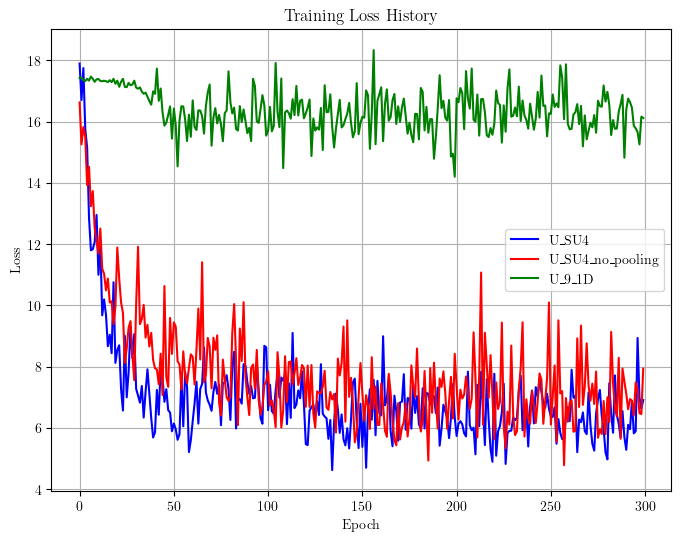

In [17]:
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(result_all[0], label=Unitaries[0], color='blue')
plt.plot(result_all[1], label=Unitaries[1], color='red')
plt.plot(result_all[2], label=Unitaries[2], color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)

# Show the plot (you may also save it as an image)
plt.show()

In [19]:
print(test_all)

[0.9886524822695035, 0.9782505910165484, 0.7371158392434988]


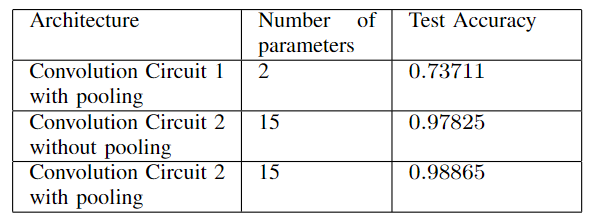

Three QCNN are evaluated, in which the use of ansatz with more parameters in QCNN provides a better accuracy. Bedises, pooling layer also improves the performance slightly compared the network without pooling layer.